In [1]:
#https://blog.roboflow.com/training-yolov4-on-a-custom-dataset/

# CUDA: Let's check that Nvidia CUDA drivers are already pre-installed and which version is it.
!/usr/local/cuda/bin/nvcc --version
# We need to install the correct cuDNN according to this output

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Wed_Jul_22_19:09:09_PDT_2020
Cuda compilation tools, release 11.0, V11.0.221
Build cuda_11.0_bu.TC445_37.28845127_0


In [2]:
# This cell ensures you have the correct architecture for your respective GPU
# If you command is not found, look through these GPUs, find the respective
# GPU and add them to the archTypes dictionary

# Tesla V100
# ARCH= -gencode arch=compute_70,code=[sm_70,compute_70]

# Tesla K80 
# ARCH= -gencode arch=compute_37,code=sm_37

# GeForce RTX 2080 Ti, RTX 2080, RTX 2070, Quadro RTX 8000, Quadro RTX 6000, Quadro RTX 5000, Tesla T4, XNOR Tensor Cores
# ARCH= -gencode arch=compute_75,code=[sm_75,compute_75]

# Jetson XAVIER
# ARCH= -gencode arch=compute_72,code=[sm_72,compute_72]

# GTX 1080, GTX 1070, GTX 1060, GTX 1050, GTX 1030, Titan Xp, Tesla P40, Tesla P4
# ARCH= -gencode arch=compute_61,code=sm_61

# GP100/Tesla P100 - DGX-1
# ARCH= -gencode arch=compute_60,code=sm_60

# For Jetson TX1, Tegra X1, DRIVE CX, DRIVE PX - uncomment:
# ARCH= -gencode arch=compute_53,code=[sm_53,compute_53]

# For Jetson Tx2 or Drive-PX2 uncomment:
# ARCH= -gencode arch=compute_62,code=[sm_62,compute_62]
import os
os.environ['GPU_TYPE'] = str(os.popen('nvidia-smi --query-gpu=name --format=csv,noheader').read())

def getGPUArch(argument):
  try:
    argument = argument.strip()
    # All Colab GPUs
    archTypes = {
        "Tesla V100-SXM2-16GB": "-gencode arch=compute_70,code=[sm_70,compute_70]",
        "Tesla K80": "-gencode arch=compute_37,code=sm_37",
        "Tesla T4": "-gencode arch=compute_75,code=[sm_75,compute_75]",
        "Tesla P40": "-gencode arch=compute_61,code=sm_61",
        "Tesla P4": "-gencode arch=compute_61,code=sm_61",
        "Tesla P100-PCIE-16GB": "-gencode arch=compute_60,code=sm_60"

      }
    return archTypes[argument]
  except KeyError:
    return "GPU must be added to GPU Commands"
os.environ['ARCH_VALUE'] = getGPUArch(os.environ['GPU_TYPE'])

print("GPU Type: " + os.environ['GPU_TYPE'])
print("ARCH Value: " + os.environ['ARCH_VALUE'])

GPU Type: Tesla T4

ARCH Value: -gencode arch=compute_75,code=[sm_75,compute_75]


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
os.chdir('/content/drive/MyDrive/Machine_Learning/Crack_Detection/Yolo_v4') #/
!pwd
%ls

/content/drive/MyDrive/Machine_Learning/Crack_Detection/Yolo_v4
backup/                           chart.png  Data.ipynb
bad.list                          darknet/   predictions.jpg
chart_custom-yolov4-detector.png  data/      Yolov4_custom_data.ipynb


In [5]:
!git clone https://github.com/roboflow-ai/darknet.git

fatal: destination path 'darknet' already exists and is not an empty directory.


In [6]:
%cd darknet
%rm Makefile

/content/drive/MyDrive/Machine_Learning/Crack_Detection/Yolo_v4/darknet


In [7]:
#colab occasionally shifts dependencies around, at the time of authorship, this Makefile works for building Darknet on Colab

%%writefile Makefile
GPU=1
CUDNN=1
CUDNN_HALF=0
OPENCV=1
AVX=0
OPENMP=0
LIBSO=1
ZED_CAMERA=0
ZED_CAMERA_v2_8=0

# set GPU=1 and CUDNN=1 to speedup on GPU
# set CUDNN_HALF=1 to further speedup 3 x times (Mixed-precision on Tensor Cores) GPU: Volta, Xavier, Turing and higher
# set AVX=1 and OPENMP=1 to speedup on CPU (if error occurs then set AVX=0)
# set ZED_CAMERA=1 to enable ZED SDK 3.0 and above
# set ZED_CAMERA_v2_8=1 to enable ZED SDK 2.X

USE_CPP=0
DEBUG=0

ARCH= -gencode arch=compute_35,code=sm_35 \
      -gencode arch=compute_50,code=[sm_50,compute_50] \
      -gencode arch=compute_52,code=[sm_52,compute_52] \
	    -gencode arch=compute_61,code=[sm_61,compute_61] \
      -gencode arch=compute_37,code=sm_37

ARCH= -gencode arch=compute_60,code=sm_60

OS := $(shell uname)

VPATH=./src/
EXEC=darknet
OBJDIR=./obj/

ifeq ($(LIBSO), 1)
LIBNAMESO=libdarknet.so
APPNAMESO=uselib
endif

ifeq ($(USE_CPP), 1)
CC=g++
else
CC=gcc
endif

CPP=g++ -std=c++11
NVCC=nvcc
OPTS=-Ofast
LDFLAGS= -lm -pthread
COMMON= -Iinclude/ -I3rdparty/stb/include
CFLAGS=-Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC

ifeq ($(DEBUG), 1)
#OPTS= -O0 -g
#OPTS= -Og -g
COMMON+= -DDEBUG
CFLAGS+= -DDEBUG
else
ifeq ($(AVX), 1)
CFLAGS+= -ffp-contract=fast -mavx -mavx2 -msse3 -msse4.1 -msse4.2 -msse4a
endif
endif

CFLAGS+=$(OPTS)

ifneq (,$(findstring MSYS_NT,$(OS)))
LDFLAGS+=-lws2_32
endif

ifeq ($(OPENCV), 1)
COMMON+= -DOPENCV
CFLAGS+= -DOPENCV
LDFLAGS+= `pkg-config --libs opencv4 2> /dev/null || pkg-config --libs opencv`
COMMON+= `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv`
endif

ifeq ($(OPENMP), 1)
CFLAGS+= -fopenmp
LDFLAGS+= -lgomp
endif

ifeq ($(GPU), 1)
COMMON+= -DGPU -I/usr/local/cuda/include/
CFLAGS+= -DGPU
ifeq ($(OS),Darwin) #MAC
LDFLAGS+= -L/usr/local/cuda/lib -lcuda -lcudart -lcublas -lcurand
else
LDFLAGS+= -L/usr/local/cuda/lib64 -lcuda -lcudart -lcublas -lcurand
endif
endif

ifeq ($(CUDNN), 1)
COMMON+= -DCUDNN
ifeq ($(OS),Darwin) #MAC
CFLAGS+= -DCUDNN -I/usr/local/cuda/include
LDFLAGS+= -L/usr/local/cuda/lib -lcudnn
else
CFLAGS+= -DCUDNN -I/usr/local/cudnn/include
LDFLAGS+= -L/usr/local/cudnn/lib64 -lcudnn
endif
endif

ifeq ($(CUDNN_HALF), 1)
COMMON+= -DCUDNN_HALF
CFLAGS+= -DCUDNN_HALF
ARCH+= -gencode arch=compute_70,code=[sm_70,compute_70]
endif

ifeq ($(ZED_CAMERA), 1)
CFLAGS+= -DZED_STEREO -I/usr/local/zed/include
ifeq ($(ZED_CAMERA_v2_8), 1)
LDFLAGS+= -L/usr/local/zed/lib -lsl_core -lsl_input -lsl_zed
#-lstdc++ -D_GLIBCXX_USE_CXX11_ABI=0
else
LDFLAGS+= -L/usr/local/zed/lib -lsl_zed
#-lstdc++ -D_GLIBCXX_USE_CXX11_ABI=0
endif
endif

OBJ=image_opencv.o http_stream.o gemm.o utils.o dark_cuda.o convolutional_layer.o list.o image.o activations.o im2col.o col2im.o blas.o crop_layer.o dropout_layer.o maxpool_layer.o softmax_layer.o data.o matrix.o network.o connected_layer.o cost_layer.o parser.o option_list.o darknet.o detection_layer.o captcha.o route_layer.o writing.o box.o nightmare.o normalization_layer.o avgpool_layer.o coco.o dice.o yolo.o detector.o layer.o compare.o classifier.o local_layer.o swag.o shortcut_layer.o activation_layer.o rnn_layer.o gru_layer.o rnn.o rnn_vid.o crnn_layer.o demo.o tag.o cifar.o go.o batchnorm_layer.o art.o region_layer.o reorg_layer.o reorg_old_layer.o super.o voxel.o tree.o yolo_layer.o gaussian_yolo_layer.o upsample_layer.o lstm_layer.o conv_lstm_layer.o scale_channels_layer.o sam_layer.o
ifeq ($(GPU), 1)
LDFLAGS+= -lstdc++
OBJ+=convolutional_kernels.o activation_kernels.o im2col_kernels.o col2im_kernels.o blas_kernels.o crop_layer_kernels.o dropout_layer_kernels.o maxpool_layer_kernels.o network_kernels.o avgpool_layer_kernels.o
endif

OBJS = $(addprefix $(OBJDIR), $(OBJ))
DEPS = $(wildcard src/*.h) Makefile include/darknet.h

all: $(OBJDIR) backup results setchmod $(EXEC) $(LIBNAMESO) $(APPNAMESO)

ifeq ($(LIBSO), 1)
CFLAGS+= -fPIC

$(LIBNAMESO): $(OBJDIR) $(OBJS) include/yolo_v2_class.hpp src/yolo_v2_class.cpp
	$(CPP) -shared -std=c++11 -fvisibility=hidden -DLIB_EXPORTS $(COMMON) $(CFLAGS) $(OBJS) src/yolo_v2_class.cpp -o $@ $(LDFLAGS)

$(APPNAMESO): $(LIBNAMESO) include/yolo_v2_class.hpp src/yolo_console_dll.cpp
	$(CPP) -std=c++11 $(COMMON) $(CFLAGS) -o $@ src/yolo_console_dll.cpp $(LDFLAGS) -L ./ -l:$(LIBNAMESO)
endif

$(EXEC): $(OBJS)
	$(CPP) -std=c++11 $(COMMON) $(CFLAGS) $^ -o $@ $(LDFLAGS)

$(OBJDIR)%.o: %.c $(DEPS)
	$(CC) $(COMMON) $(CFLAGS) -c $< -o $@

$(OBJDIR)%.o: %.cpp $(DEPS)
	$(CPP) -std=c++11 $(COMMON) $(CFLAGS) -c $< -o $@

$(OBJDIR)%.o: %.cu $(DEPS)
	$(NVCC) $(ARCH) $(COMMON) --compiler-options "$(CFLAGS)" -c $< -o $@

$(OBJDIR):
	mkdir -p $(OBJDIR)
backup:
	mkdir -p backup
results:
	mkdir -p results
setchmod:
	chmod +x *.sh

.PHONY: clean

clean:
	rm -rf $(OBJS) $(EXEC) $(LIBNAMESO) $(APPNAMESO)

Writing Makefile


In [8]:
#install environment from the Makefile
#note if you are on Colab Pro this works on a P100 GPU
#if you are on Colab free, you may need to change the Makefile for the K80 GPU
#this goes for any GPU, you need to change the Makefile to inform darknet which GPU you are running on.
#note the Makefile above should work for you, if you need to tweak, try the below
#%cd /content/darknet/
!sed -i 's/OPENCV=0/OPENCV=1/g' Makefile
!sed -i 's/GPU=0/GPU=1/g' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/g' Makefile
!sed -i "s/ARCH= -gencode arch=compute_60,code=sm_60/ARCH= ${ARCH_VALUE}/g" Makefile
!make

chmod +x *.sh
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -Ofast -DOPENCV -DGPU -DCUDNN -I/usr/local/cudnn/include -fPIC -c ./src/image_opencv.cpp -o obj/image_opencv.o
./src/image_opencv.cpp: In function ‘void draw_detections_cv_v3(void**, detection*, int, float, char**, image**, int, int)’:
./src/image_opencv.cpp:910:23: warning: variable ‘rgb’ set but not used [-Wunused-but-set-variable]
                 float rgb[3];
                       ^~~
./src/image_opencv.cpp: In function ‘void cv_draw_object(image, float*, int, int, int*, float*, int*, int, char**)’:
./src/image_opencv.cpp:1391:14: warning: unused variable ‘buff’ [-Wunused-variable]
         char buff[100];
              ^~~~
./src/image_opencv.cpp:1367:9: warning: unused variable ‘it_tb_res’ [-Wunused-variable]
     int 

In [9]:
#download the newly released yolov4 ConvNet weights
!wget https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v3_optimal/yolov4.conv.137

In [10]:
%cd ..
!pwd
%ls

/content/drive/MyDrive/Machine_Learning/Crack_Detection/Yolo_v4
/content/drive/MyDrive/Machine_Learning/Crack_Detection/Yolo_v4
backup/                           chart.png  Data.ipynb
bad.list                          darknet/   predictions.jpg
chart_custom-yolov4-detector.png  data/      Yolov4_custom_data.ipynb


In [16]:
#we build config dynamically based on number of classes
#we build iteratively from base config files. This is the same file shape as cfg/yolo-obj.cfg
def file_len(fname):
  with open(fname) as f:
    for i, l in enumerate(f):
      pass
  return i + 1

num_classes = file_len('data/train/classes.names')
print("writing config for a custom YOLOv4 detector detecting number of classes: " + str(num_classes))

#Instructions from the darknet repo
#change line max_batches to (classes*2000 but not less than number of training images, and not less than 6000), f.e. max_batches=6000 if you train for 3 classes
#change line steps to 80% and 90% of max_batches, f.e. steps=4800,5400
if os.path.exists('darknet/cfg/custom-yolov4-detector.cfg'): os.remove('darknet/cfg/custom-yolov4-detector.cfg')

with open('darknet/cfg/custom-yolov4-detector.cfg', 'a') as f:
  f.write('[net]' + '\n')
  f.write('batch=32' + '\n')
  #####smaller subdivisions help the GPU run faster. 12 is optimal, but you might need to change to 24,36,64####
  f.write('subdivisions=8' + '\n')
  f.write('width=352' + '\n')
  f.write('height=352' + '\n')
  f.write('channels=3' + '\n')
  f.write('momentum=0.949' + '\n')
  f.write('decay=0.0005' + '\n')
  f.write('angle=90' + '\n')
  f.write('saturation = 1.5' + '\n')
  f.write('exposure = 1.5' + '\n')
  f.write('hue = .1' + '\n')
  f.write('\n')
  f.write('learning_rate=0.00002' + '\n')#0.001
  f.write('burn_in=100' + '\n')#1000
  ######you can adjust up and down to change training time#####
  ##Darknet does iterations with batches, not epochs####
  # max_batches = num_classes*2000
  max_batches = 4000
  f.write('max_batches=' + str(max_batches) + '\n')
  f.write('policy=steps' + '\n')
  steps1 = 3200#.8 * max_batches
  steps2 = 3600#.9 * max_batches
  f.write('steps='+str(steps1)+','+str(steps2) + '\n')

#Instructions from the darknet repo
#change line classes=80 to your number of objects in each of 3 [yolo]-layers:
#change [filters=255] to filters=(classes + 5)x3 in the 3 [convolutional] before each [yolo] layer, keep in mind that it only has to be the last [convolutional] before each of the [yolo] layers.

  with open('darknet/cfg/yolov4-custom2.cfg', 'r') as f2:
    content = f2.readlines()
    for line in content:
      f.write(line)    
    num_filters = (num_classes + 5) * 3
    f.write('filters='+str(num_filters) + '\n')
    f.write('activation=linear')
    f.write('\n')
    f.write('\n')
    f.write('[yolo]' + '\n')
    f.write('mask = 0,1,2' + '\n')
    f.write('anchors = 45.67,30.76, 52.41,71.55, 90.05,94.93, 126.47,39.89, 199.16,102.75, 224.01,54.53, 262.84,116.67, 263.25,43.63, 281.90,89.67' + '\n')
    f.write('classes=' + str(num_classes) + '\n')

  with open('darknet/cfg/yolov4-custom3.cfg', 'r') as f3:
    content = f3.readlines()
    for line in content:
      f.write(line)    
    num_filters = (num_classes + 5) * 3
    f.write('filters='+str(num_filters) + '\n')
    f.write('activation=linear')
    f.write('\n')
    f.write('\n')
    f.write('[yolo]' + '\n')
    f.write('mask = 3,4,5' + '\n')
    f.write('anchors = 45.67,30.76, 52.41,71.55, 90.05,94.93, 126.47,39.89, 199.16,102.75, 224.01,54.53, 262.84,116.67, 263.25,43.63, 281.90,89.67' + '\n')
    f.write('classes=' + str(num_classes) + '\n')

  with open('darknet/cfg/yolov4-custom4.cfg', 'r') as f4:
    content = f4.readlines()
    for line in content:
      f.write(line)    
    num_filters = (num_classes + 5) * 3
    f.write('filters='+str(num_filters) + '\n')
    f.write('activation=linear')
    f.write('\n')
    f.write('\n')
    f.write('[yolo]' + '\n')
    f.write('mask = 6,7,8' + '\n')
    f.write('anchors = 45.67,30.76, 52.41,71.55, 90.05,94.93, 126.47,39.89, 199.16,102.75, 224.01,54.53, 262.84,116.67, 263.25,43.63, 281.90,89.67' + '\n')
    f.write('classes=' + str(num_classes) + '\n')
    
  with open('darknet/cfg/yolov4-custom5.cfg', 'r') as f5:
    content = f5.readlines()
    for line in content:
      f.write(line)

print("train_config file is written!")

if os.path.exists('darknet/cfg/custom-yolov4-test.cfg'): os.remove('darknet/cfg/custom-yolov4-test.cfg')

with open('darknet/cfg/custom-yolov4-test.cfg', 'a') as f:
  f.write('[net]' + '\n')
  f.write('batch=1' + '\n')
  #####smaller subdivisions help the GPU run faster. 12 is optimal, but you might need to change to 24,36,64####
  f.write('subdivisions=1' + '\n')
  f.write('width=352' + '\n')
  f.write('height=352' + '\n')
  f.write('channels=3' + '\n')
  f.write('momentum=0.949' + '\n')
  f.write('decay=0.0005' + '\n')
  f.write('angle=90' + '\n')
  f.write('saturation = 1.5' + '\n')
  f.write('exposure = 1.5' + '\n')
  f.write('hue = .1' + '\n')
  f.write('\n')
  f.write('learning_rate=0.00002' + '\n')#0.001
  f.write('burn_in=100' + '\n')#1000
  ######you can adjust up and down to change training time#####
  ##Darknet does iterations with batches, not epochs####
  # max_batches = num_classes*2000
  max_batches = 4000
  f.write('max_batches=' + str(max_batches) + '\n')
  f.write('policy=steps' + '\n')
  steps1 = 3200#.8 * max_batches
  steps2 = 3600#.9 * max_batches
  f.write('steps='+str(steps1)+','+str(steps2) + '\n')

#Instructions from the darknet repo
#change line classes=80 to your number of objects in each of 3 [yolo]-layers:
#change [filters=255] to filters=(classes + 5)x3 in the 3 [convolutional] before each [yolo] layer, keep in mind that it only has to be the last [convolutional] before each of the [yolo] layers.

  with open('darknet/cfg/yolov4-custom2.cfg', 'r') as f2:
    content = f2.readlines()
    for line in content:
      f.write(line)    
    num_filters = (num_classes + 5) * 3
    f.write('filters='+str(num_filters) + '\n')
    f.write('activation=linear')
    f.write('\n')
    f.write('\n')
    f.write('[yolo]' + '\n')
    f.write('mask = 0,1,2' + '\n')
    f.write('anchors = 45.67,30.76, 52.41,71.55, 90.05,94.93, 126.47,39.89, 199.16,102.75, 224.01,54.53, 262.84,116.67, 263.25,43.63, 281.90,89.67' + '\n')
    f.write('classes=' + str(num_classes) + '\n')

  with open('darknet/cfg/yolov4-custom3.cfg', 'r') as f3:
    content = f3.readlines()
    for line in content:
      f.write(line)    
    num_filters = (num_classes + 5) * 3
    f.write('filters='+str(num_filters) + '\n')
    f.write('activation=linear')
    f.write('\n')
    f.write('\n')
    f.write('[yolo]' + '\n')
    f.write('mask = 3,4,5' + '\n')
    f.write('anchors = 45.67,30.76, 52.41,71.55, 90.05,94.93, 126.47,39.89, 199.16,102.75, 224.01,54.53, 262.84,116.67, 263.25,43.63, 281.90,89.67' + '\n')
    f.write('classes=' + str(num_classes) + '\n')
    
  with open('darknet/cfg/yolov4-custom4.cfg', 'r') as f4:
    content = f4.readlines()
    for line in content:
      f.write(line)    
    num_filters = (num_classes + 5) * 3
    f.write('filters='+str(num_filters) + '\n')
    f.write('activation=linear')
    f.write('\n')
    f.write('\n')
    f.write('[yolo]' + '\n')
    f.write('mask = 6,7,8' + '\n')
    f.write('anchors = 45.67,30.76, 52.41,71.55, 90.05,94.93, 126.47,39.89, 199.16,102.75, 224.01,54.53, 262.84,116.67, 263.25,43.63, 281.90,89.67' + '\n')
    f.write('classes=' + str(num_classes) + '\n')
    
  with open('darknet/cfg/yolov4-custom5.cfg', 'r') as f5:
    content = f5.readlines()
    for line in content:
      f.write(line)

print("test_config file is written!")


writing config for a custom YOLOv4 detector detecting number of classes: 1
train_config file is written!
test_config file is written!


In [ ]:
! ./darknet/darknet detector train data/train/custom_data.data darknet/cfg/custom-yolov4-detector.cfg backup/custom-yolov4-detector_best.weights -dont_show -map #backup/custom-yolov4-detector_last.weights #darknet/yolov4.conv.13

#mAP: mean average precision
#https://blog.roboflow.com/mean-average-precision/

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
 (next mAP calculation at 3200 iterations) 
 Last accuracy mAP@0.5 = 79.30 %, best = 89.78 % 
 3130: 2.701308, 2.264925 avg loss, 0.000020 rate, 2.823034 seconds, 100160 images, 0.686660 hours left
Resizing, random_coef = 1.40 

 352 x 352 
Can't open label file. (This can be normal only if you use MSCOCO): data/train/Neg_01100.txt 
 try to allocate additional workspace_size = 52.43 MB 
 CUDA allocate done! 
Loaded: 0.135135 seconds - performance bottleneck on CPU or Disk HDD/SSD
Can't open label file. (This can be normal only if you use MSCOCO): data/train/Neg_01100.txt 

 (next mAP calculation at 3200 iterations) 
 Last accuracy mAP@0.5 = 79.30 %, best = 89.78 % 
 3131: 2.795871, 2.318020 avg loss, 0.000020 rate, 2.039252 seconds, 100192 images, 0.686616 hours left
Loaded: 0.000053 seconds
Can't open label file. (This can be normal only if you use MSCOCO): data/train/Neg_01100.txt 
Can't open label file. (T

In [18]:
#define utility function
def imShow(path):
  import cv2
  import matplotlib.pyplot as plt
  %matplotlib inline

  image = cv2.imread(path)
  height, width = image.shape[:2]
  resized_image = cv2.resize(image,(3*width, 3*height), interpolation = cv2.INTER_CUBIC)

  fig = plt.gcf()
  fig.set_size_inches(18, 10)
  plt.axis("off")
  plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
  plt.show()

In [19]:
#check if weigths have saved yet
!ls backup

custom-yolov4-detector_3000.weights  custom-yolov4-detector_final.weights
custom-yolov4-detector_best.weights  custom-yolov4-detector_last.weights


 CUDA-version: 11000 (11020), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
Cannot load image data/labels/32_0.png
Cannot load image data/labels/33_0.png
Cannot load image data/labels/34_0.png
Cannot load image data/labels/35_0.png
Cannot load image data/labels/36_0.png
Cannot load image data/labels/37_0.png
Cannot load image data/labels/38_0.png
Cannot load image data/labels/39_0.png
Cannot load image data/labels/40_0.png
Cannot load image data/labels/41_0.png
Cannot load image data/labels/42_0.png
Cannot load image data/labels/43_0.png
Cannot load image data/labels/44_0.png
Cannot load image data/labels/45_0.png
Cannot load image data/labels/46_0.png
Cannot load image data/labels/47_0.png
Cannot load image data/labels/48_0.png
Cannot load image data/labels/49_0.png
Cannot load image data/labels/50_0.png
Cannot load image data/labels/51_0.png
Cannot load image data/labels/52_0.png
Cannot load image data/labels/53_0.png
Cannot load image data/labels/54_0.png
Cannot load image dat

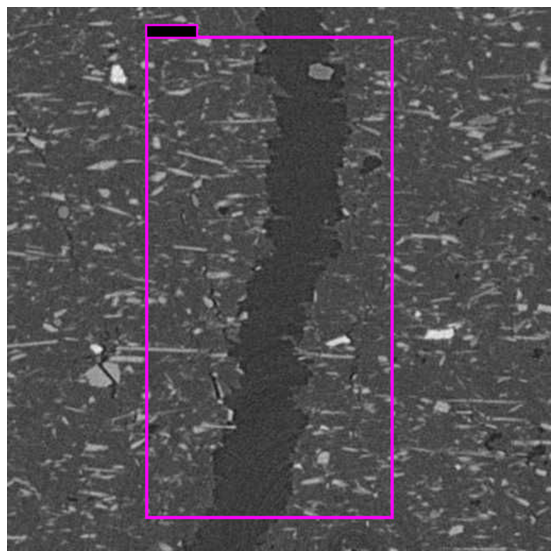

In [34]:
#/test has images that we can test our detector on
test_images = [f for f in os.listdir('data/test') if f.endswith('.jpg')]

import random
img_path = "data/test/" + random.choice(test_images);

#test out our detector!
!./darknet/darknet detector test data/train/custom_data.data darknet/cfg/custom-yolov4-test.cfg backup/custom-yolov4-detector_best.weights {img_path} -thresh 0.6 -dont_show
imShow('predictions.jpg')